## Importing the input vectors

In [1]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Run the data preparation notebook
X_lstm = np.load("npy_files/X_lstm.npy")
anomaly_list = np.load("npy_files/anomaly_list.npy") #0 for normal. 1 for anomaly


In [2]:
X_lstm.shape

(6711, 7, 9)

In [3]:
pd.DataFrame(X_lstm[0,:,:])

0       1     2    3     4     5    6     7     8
0  8.368  5.5425   0.0  8.0   6.0   0.0  0.0   8.0   8.0
1  9.692  6.1375   1.0  9.0   5.0   1.0  0.0  10.0  10.0
2  9.780  3.6950  25.0  0.0  25.0  25.0  0.0  25.0  25.0
3  9.364  3.7175  25.0  0.0  25.0  25.0  0.0  25.0  25.0
4  8.960  0.0425  26.0  0.0  26.0  26.0  0.0  26.0  26.0
5  8.588  0.0425  25.0  0.0  25.0  25.0  0.0  25.0  25.0
6  8.244  0.0425  24.0  2.0  26.0  24.0  0.0  26.0  26.0

#### Deciding the different sets' sizes and positions

In [4]:
'''from matplotlib.patches import Patch
labels_int = [int(label) for label in labels]

# Plot the labels as a function of the index
plt.figure(figsize=(10, 4))
plt.plot(labels_int, 'b.-', label='Labels')
plt.fill_between(range(len(labels)), 0, 1, where=(np.arange(len(labels)) >= split_index) & (np.arange(len(labels)) < split_index2), color='red', alpha=0.3)
plt.fill_between(range(len(labels)), 0, 1, where=(np.arange(len(labels)) >= split_index2), color='blue', alpha=0.3)
legend_elements = [Patch(facecolor='white', edgecolor='black', alpha=0.3, label='Train Region'),
                   Patch(facecolor='red', edgecolor='r', alpha=0.3, label='Validation Region'),
                   Patch(facecolor='blue', edgecolor='b', alpha=0.3, label='Test Region')]
plt.legend(handles=legend_elements, loc='upper right')

plt.xlabel('Index')
plt.ylabel('Anomaly?')
plt.title('Labels as a Function of Index')
plt.grid(True)
plt.show()'''

"from matplotlib.patches import Patch\nlabels_int = [int(label) for label in labels]\n\n# Plot the labels as a function of the index\nplt.figure(figsize=(10, 4))\nplt.plot(labels_int, 'b.-', label='Labels')\nplt.fill_between(range(len(labels)), 0, 1, where=(np.arange(len(labels)) >= split_index) & (np.arange(len(labels)) < split_index2), color='red', alpha=0.3)\nplt.fill_between(range(len(labels)), 0, 1, where=(np.arange(len(labels)) >= split_index2), color='blue', alpha=0.3)\nlegend_elements = [Patch(facecolor='white', edgecolor='black', alpha=0.3, label='Train Region'),\n                   Patch(facecolor='red', edgecolor='r', alpha=0.3, label='Validation Region'),\n                   Patch(facecolor='blue', edgecolor='b', alpha=0.3, label='Test Region')]\nplt.legend(handles=legend_elements, loc='upper right')\n\nplt.xlabel('Index')\nplt.ylabel('Anomaly?')\nplt.title('Labels as a Function of Index')\nplt.grid(True)\nplt.show()"

In [5]:
'''sum(anomaly_list)/len(anomaly_list)'''

'sum(anomaly_list)/len(anomaly_list)'

In [6]:
from collections import Counter
'''def calculate_proportions(labels):
    counter = Counter(labels)
    total = len(labels)
    true_proportion = counter[True] / total
    false_proportion = counter[False] / total
    return true_proportion, false_proportion

# Calculate proportions for each list
train_true_prop, train_false_prop = calculate_proportions(train_labels)
val_true_prop, val_false_prop = calculate_proportions(val_labels)
test_true_prop, test_false_prop = calculate_proportions(test_labels)
# Print the proportions
print(f"Train Labels ({len(train_labels)} samples) -     Normal: {train_false_prop*100:.2f}%, Anomalous: {train_true_prop*100:.2f}%")
print(f"Validation Labels ({len(val_labels)} samples) - Normal: {val_false_prop*100:.2f}%, Anomalous: {val_true_prop*100:.2f}%")
print(f"Test Labels ({len(test_labels)} samples) -       Normal: {test_false_prop*100:.2f}%, Anomalous: {test_true_prop*100:.2f}%")'''


'def calculate_proportions(labels):\n    counter = Counter(labels)\n    total = len(labels)\n    true_proportion = counter[True] / total\n    false_proportion = counter[False] / total\n    return true_proportion, false_proportion\n\n# Calculate proportions for each list\ntrain_true_prop, train_false_prop = calculate_proportions(train_labels)\nval_true_prop, val_false_prop = calculate_proportions(val_labels)\ntest_true_prop, test_false_prop = calculate_proportions(test_labels)\n# Print the proportions\nprint(f"Train Labels ({len(train_labels)} samples) -     Normal: {train_false_prop*100:.2f}%, Anomalous: {train_true_prop*100:.2f}%")\nprint(f"Validation Labels ({len(val_labels)} samples) - Normal: {val_false_prop*100:.2f}%, Anomalous: {val_true_prop*100:.2f}%")\nprint(f"Test Labels ({len(test_labels)} samples) -       Normal: {test_false_prop*100:.2f}%, Anomalous: {test_true_prop*100:.2f}%")'

#### Defining Autoencoder, loss and prediction functions

In [7]:
# Define input dimension
timesteps = 7 #7 timesteps
features = 9 #9 features

# Encoder: Three layers plus bottleneck
input_layer = Input(shape=(timesteps, features), name='input')
encoded = LSTM(32, return_sequences=True, activation='sigmoid', name='encoder_1')(input_layer)
encoded = LSTM(16, return_sequences=False, activation='sigmoid', name='bottleneck')(encoded)

# Decoder: Three layers mirroring the encoder
decoded = RepeatVector(timesteps, name='repeat_vector')(encoded)
decoded = LSTM(16, return_sequences=True, activation='sigmoid', name='decoder_1')(decoded)
decoded = LSTM(32, return_sequences=True, activation='sigmoid', name='decoder_2')(decoded)
output_layer = TimeDistributed(Dense(features), name='output')(decoded)


autoencoder = Model(input_layer, output_layer)

# Custom loss function class
class SparseAutoencoderLoss(tf.keras.losses.Loss):
    def __init__(self, model, lambda_reg=1e-3, beta=1e-5, sparsity_target=0.05):
        super(SparseAutoencoderLoss, self).__init__()
        self.model = model
        self.lambda_reg = lambda_reg
        self.beta = beta
        self.sparsity_target = sparsity_target

    def get_layer_activations(self, data):
        layer_outputs = [layer.output for layer in self.model.layers if 'encoder_1' in layer.name or 'bottleneck' in layer.name 
                         or 'decoder_1' in layer.name or 'decoder_2' in layer.name]
        activation_model = Model(inputs=self.model.input, outputs=layer_outputs)
        activations = activation_model(data)
        return activations

    def call(self, y_true, y_pred):
        # Mean Squared Error
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

        # Frobenius norm
        frobenius_loss = 0
        for layer in self.model.layers:
            if hasattr(layer, 'kernel'):
                frobenius_loss += tf.reduce_sum(tf.square(layer.kernel))
        frobenius_loss *= self.lambda_reg

        # Kullback-Leibler divergence
        activations = self.get_layer_activations(y_true)
        kl_divergence = 0
        for activation in activations:
            rho_hat = tf.reduce_mean(activation, axis=0)  # Average activation per neuron
            rho_hat = tf.clip_by_value(rho_hat, 1e-5, 1 - 1e-5)
            kl_divergence += tf.reduce_sum( #reduce_sum takes the entire rho_hat vector and sums it up in the formula
            0.01 * tf.math.log(0.01 / (rho_hat + 1e-5)) +
            (1 - 0.01) * tf.math.log((1 - 0.01) / (1 - rho_hat + 1e-5))
            )
        kl_loss = self.beta * kl_divergence

        # Total loss
        return mse_loss + frobenius_loss + kl_loss
    

# Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.reduce_mean(tf.keras.losses.mae(reconstructions, data), axis=1)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}%".format(100*accuracy_score(~labels, predictions)))
    print("Precision = {}%".format(100*precision_score(~labels, predictions, pos_label=0)))
    print("Recall = {}%".format(100*recall_score(~labels, predictions, pos_label=0)))
    print("F1 Score = {}%".format(100*f1_score(~labels, predictions, pos_label=0)))

#### Boundary condition: the primordial run

In [8]:
#Boundary condition: primordial run

# The last element contains the labels
labels = anomaly_list
# The other data points are the data
data = X_lstm

#new variables for the moving window problem
test_loss = []
preds_list = []
threshold_list = []

normal_train_data = np.empty((0, 7, 9))  # Empty array with correct shape
anomalous_train_data = np.empty((0, 7, 9))
normal_val_data = np.empty((0, 7, 9))
anomalous_val_data = np.empty((0, 7, 9))

test_cycle_normalized = np.empty((1, 7, 9))
test_cycle = np.empty((1, 7, 9))
good_cycles = np.empty((1,7,9))


# Determine the split index (see image below: the train and validation sets will use only good data. Mixed data is desirable for testing)
split_index = 2865 #June 1st index
split_index2 = 4670 #July 1st index

# Split the data and labels
train_data = data[:split_index]
val_data = data[split_index:split_index2]
test_data = data[split_index2:]# Assuring we only test 1 sample at a time
test_cycle[0,:,:] = test_data[0,:,:]

train_labels = labels[:split_index]
val_labels = labels[split_index:split_index2]
test_labels = labels[split_index2:]# Assuring we only test 1 sample at a time
test_cycle_label = test_labels[0]

#Pass to boolean
train_labels = train_labels.astype(bool)
val_labels = val_labels.astype(bool)
test_labels = test_labels.astype(bool)

#Pass to float
train_data = tf.cast(train_data, tf.float32)
val_data = tf.cast(val_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

train_data = train_data.numpy()
val_data = val_data.numpy()
test_data = test_data.numpy()

#Separate into normal and anomalous data
for i in range(len(train_labels)):
    if train_labels[i] == 0:
        normal_train_data = np.concatenate((normal_train_data, train_data[i:i+1, :, :]), axis=0)
    else:
        anomalous_train_data = np.concatenate((anomalous_train_data, train_data[i:i+1, :, :]), axis=0)

for i in range(len(val_labels)):
    if val_labels[i] == 0:
        normal_val_data = np.concatenate((normal_val_data, val_data[i:i+1, :, :]), axis=0)
    else:
        anomalous_val_data = np.concatenate((anomalous_val_data, val_data[i:i+1, :, :]), axis=0)

'''for i in range(len(test_labels)):
    if test_labels[i] == 0:
        normal_test_data = np.concatenate((normal_test_data, test_data[i:i+1, :, :]), axis=0)
    else:
        anomalous_test_data = np.concatenate((anomalous_test_data, test_data[i:i+1, :, :]), axis=0)'''





# Initialize the MinMaxScaler
scaler = MinMaxScaler()

train_reshaped = train_data.reshape(-1, 9)  # Reshape to (#_samples * 7, 9)
train_scaled = scaler.fit_transform(train_reshaped)  # Fit and transform
train_data_normalized = train_scaled.reshape(train_data.shape)  # Reshape back

val_reshaped = val_data.reshape(-1, 9)  # Reshape to (#_samples * 7, 9)
val_scaled = scaler.transform(val_reshaped)  # Transform (using the scaler fitted on train data)
val_data_normalized = val_scaled.reshape(val_data.shape)  # Reshape back

test_reshaped = test_data.reshape(-1, 9)  # Reshape to (#_samples * 7, 9)
test_scaled = scaler.transform(test_reshaped)  # Transform (using the scaler fitted on train data)
test_data_normalized = test_scaled.reshape(test_data.shape)  # Reshape back
test_cycle_normalized[0,:,:] =  test_data_normalized[0,:,:]

# Reshape the normal training data to 2D, fit the scaler, and transform it
normal_train_reshaped = normal_train_data.reshape(-1, 9)  # Reshape to (#_samples * 7, 9)
normal_train_scaled = scaler.fit_transform(normal_train_reshaped)  # Fit and transform
normal_train_data_normalized = normal_train_scaled.reshape(normal_train_data.shape)  # Reshape back

# Reshape and transform the rest of the datasets using the same scaler
# Normal validation data
normal_val_reshaped = normal_val_data.reshape(-1, 9)
normal_val_scaled = scaler.transform(normal_val_reshaped)
normal_val_data_normalized = normal_val_scaled.reshape(normal_val_data.shape)

'''# Normal test data
normal_test_reshaped = normal_test_data.reshape(-1, 9)
normal_test_scaled = scaler.transform(normal_test_reshaped)
normal_test_data = normal_test_scaled.reshape(normal_test_data.shape)'''

# Anomalous training data
anomalous_train_reshaped = anomalous_train_data.reshape(-1, 9)
anomalous_train_scaled = scaler.transform(anomalous_train_reshaped)
anomalous_train_data_normalized = anomalous_train_scaled.reshape(anomalous_train_data.shape)

# Anomalous validation data
anomalous_val_reshaped = anomalous_val_data.reshape(-1, 9)
anomalous_val_scaled = scaler.transform(anomalous_val_reshaped)
anomalous_val_data_normalized = anomalous_val_scaled.reshape(anomalous_val_data.shape)

'''# Anomalous test data
anomalous_test_reshaped = anomalous_test_data.reshape(-1, 9)
anomalous_test_scaled = scaler.transform(anomalous_test_reshaped)
anomalous_test_data = anomalous_test_scaled.reshape(anomalous_test_data.shape)'''








# Compile the model with the custom loss
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='mae'#SparseAutoencoderLoss(model=autoencoder, lambda_reg=1e-5, beta=0.5, sparsity_target=0.01)
)

# Train the model
history = autoencoder.fit(
    x=normal_train_data_normalized,  # Input and target are the same for autoencoders
    y=normal_train_data_normalized,  # Input and target are the same for autoencoders
    epochs=100, 
    batch_size=30, 
    validation_data=(normal_val_data_normalized, normal_val_data_normalized)
)






# Classify an ECG as anomalous if the reconstruction error is greater than one standard deviation
reconstructions_normal = autoencoder.predict(normal_val_data_normalized)
val_loss = tf.reduce_mean(tf.keras.losses.mae(reconstructions_normal, normal_val_data_normalized), axis=1)

# Compute the first quartile (Q1) and third quartile (Q3)
Q1 = np.percentile(val_loss, 25)
Q3 = np.percentile(val_loss, 75)
IQR = Q3 - Q1
# Define the threshold using Tukey's fence - 1.5 for outliers. 3 for far-out results
k = 6
threshold = Q3 + k * IQR
threshold_list.append(threshold)
print("Threshold: ", threshold)

# Calculate the reconstruction loss for the anomalous test data
reconstructions_test = autoencoder.predict(test_cycle_normalized)
pred_aux = predict(autoencoder, test_cycle_normalized, threshold)
preds_list.append(pred_aux)

test_loss.append(tf.reduce_mean(tf.keras.losses.mae(reconstructions_test, test_cycle_normalized), axis=1))

if pred_aux == True:
    good_cycles[0,:,:] = test_cycle[0,:,:]

Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1469 - val_loss: 0.0404
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0392 - val_loss: 0.0245
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0235 - val_loss: 0.0154
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0188 - val_loss: 0.0166
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0196 - val_loss: 0.0166
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0172 - val_loss: 0.0163
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0188 - val_loss: 0.0173
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0174 - val_loss: 0.0187
Epoch 9/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0169 - val_loss: 0.0171
Epoch 10/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0158 - val_loss: 0.0144
Epoch 11/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0146 - val_loss: 0.0157
Epoch 12/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.

In [9]:
good_cycles.shape

(1, 7, 9)

#### Moving window

In [10]:
num_batches = 5
for n in range(len(anomaly_list)-4670-1):
    print(f"Cycle: {n+1}/{len(anomaly_list)-4670}")
    print(f"good_cycle shape: {good_cycles.shape}")
    print(f"Normal train data: {normal_train_data.shape[0]}\t Normal val data: {normal_val_data.shape[0]}\t Test data: {test_data.shape[0]}")  
    if good_cycles.shape[0] == num_batches:  
        
        normal_train_data = np.append(normal_train_data, normal_val_data[:num_batches], axis=0)
        normal_val_data = np.append(normal_val_data, good_cycles, axis=0)
        normal_val_data = np.delete(normal_val_data, np.s_[:num_batches], axis=0)

        good_cycles = np.empty((1,7,9))


        # Initialize the MinMaxScaler
        scaler = MinMaxScaler()
        
        # Reshape the normal training data to 2D, fit the scaler, and transform it
        normal_train_reshaped = normal_train_data.reshape(-1, 9)  # Reshape to (#_samples * 7, 9)
        normal_train_scaled = scaler.fit_transform(normal_train_reshaped)  # Fit and transform
        normal_train_data_normalized = normal_train_scaled.reshape(normal_train_data.shape)  # Reshape back

        # Reshape and transform the rest of the datasets using the same scaler
        # Normal validation data
        normal_val_reshaped = normal_val_data.reshape(-1, 9)
        normal_val_scaled = scaler.transform(normal_val_reshaped)
        normal_val_data_normalized = normal_val_scaled.reshape(normal_val_data.shape)

        test_data = np.delete(test_data, np.s_[:1], axis=0)
        test_cycle[0,:,:] = test_data[0,:,:]
        test_reshaped = test_data.reshape(-1, 9)  # Reshape to (#_samples * 7, 9)
        test_scaled = scaler.transform(test_reshaped)  # Transform (using the scaler fitted on train data)
        test_data_normalized = test_scaled.reshape(test_data.shape)  # Reshape back
        test_cycle_normalized[0,:,:] = test_data_normalized[0,:,:]




        # Compile the model with the custom loss
        autoencoder.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
            loss='mae'#SparseAutoencoderLoss(model=autoencoder, lambda_reg=1e-5, beta=0.5, sparsity_target=0.01)
        )

        # Train the model
        history = autoencoder.fit(
            x=normal_train_data_normalized,  # Input and target are the same for autoencoders
            y=normal_train_data_normalized,  # Input and target are the same for autoencoders
            epochs=100, 
            batch_size=30, 
            validation_data=(normal_val_data_normalized, normal_val_data_normalized)
        )





        # Classify an ECG as anomalous if the reconstruction error is greater than one standard deviation
        reconstructions_normal = autoencoder.predict(normal_val_data_normalized)
        val_loss = tf.reduce_mean(tf.keras.losses.mae(reconstructions_normal, normal_val_data_normalized), axis=1)

        # Compute the first quartile (Q1) and third quartile (Q3)
        Q1 = np.percentile(val_loss, 25)
        Q3 = np.percentile(val_loss, 75)
        IQR = Q3 - Q1
        # Define the threshold using Tukey's fence - 1.5 for outliers. 3 for far-out results
        k = 6
        threshold = Q3 + k * IQR
        threshold_list.append(threshold)

        # Calculate the reconstruction loss for the anomalous test data
        reconstructions_test = autoencoder.predict(test_cycle_normalized)
        pred_aux = predict(autoencoder, test_cycle_normalized, threshold)
        preds_list.append(pred_aux)

        test_loss.append(tf.reduce_mean(tf.keras.losses.mae(reconstructions_test, test_cycle_normalized), axis=1))

        if pred_aux == True:
            good_cycles = np.concatenate((good_cycles, test_cycle), axis=0)



    else: 
        try:
            test_data = np.delete(test_data, np.s_[:1], axis=0)
            test_cycle[0,:,:] = test_data[0,:,:]
            test_data_normalized = np.delete(test_data_normalized, np.s_[:1], axis=0)
            test_cycle_normalized[0,:,:] = test_data_normalized[0,:,:]

            reconstructions_test = autoencoder.predict(test_cycle_normalized)
            test_loss.append(tf.reduce_mean(tf.keras.losses.mae(reconstructions_test, test_cycle_normalized), axis=1))

            pred_aux = predict(autoencoder, test_cycle_normalized, threshold)
            preds_list.append(pred_aux)

            if pred_aux == True:
                good_cycles = np.concatenate((good_cycles, test_cycle), axis=0)
        except:
            print("End of test data")

Cycle: 1/2041
good_cycle shape: (1, 7, 9)
Normal train data: 2469	 Normal val data: 1539	 Test data: 2041
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Cycle: 2/2041
good_cycle shape: (2, 7, 9)
Normal train data: 2469	 Normal val data: 1539	 Test data: 2040
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Cycle: 3/2041
good_cycle shape: (3, 7, 9)
Normal train data: 2469	 Normal val data: 1539	 Test data: 2039
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Cycle: 4/2041
good_cycle shape: (4, 7, 9)
Normal train data: 2469	 Normal val data: 1539	 Test data: 2038
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Cycle: 5/2041
good_cycle shape: (5, 7, 9)
Normal train data: 2469	 Normal val data: 1539	 Test data: 2037
Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0079 - val_loss: 0.0046
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0043 - val_loss: 0.0038
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0

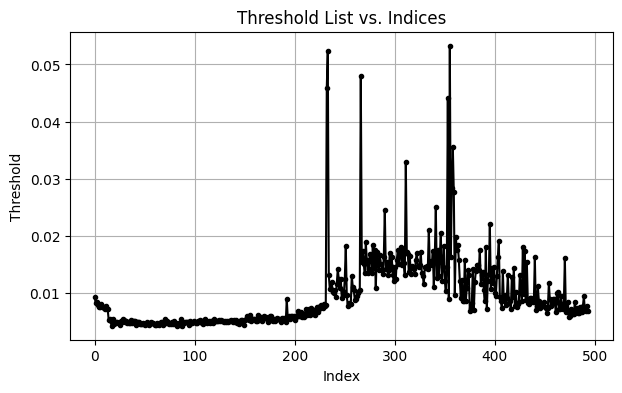

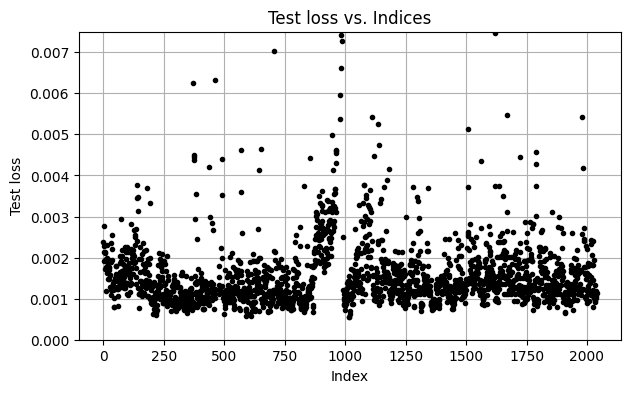

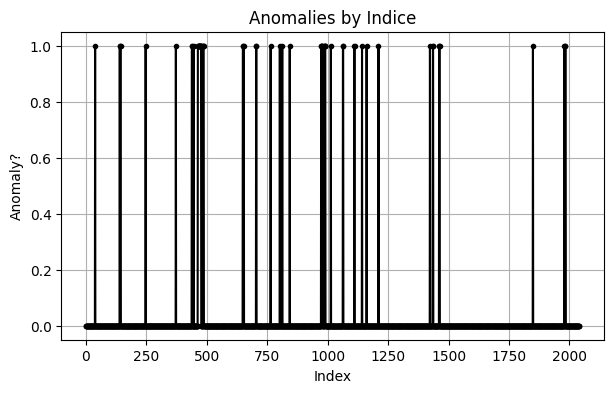

In [11]:
# Plot threshold_list against the respective indices
plt.figure(figsize=(7, 4))
plt.plot(threshold_list, marker='.', linestyle='-', color='black')
plt.xlabel('Index')
plt.ylabel('Threshold')
plt.title('Threshold List vs. Indices')
plt.grid(True)
#plt.ylim(0,0.0075)
plt.show()


# Plot test_loss against the respective indices
plt.figure(figsize=(7, 4))
plt.plot(test_loss, marker='.', linestyle=' ', color='black')
plt.xlabel('Index')
plt.ylabel('Test loss')
plt.title('Test loss vs. Indices')
plt.grid(True)
plt.ylim(0,0.0075)
plt.show()



# Convert boolean values: True -> 0, False -> 1
plot_preds_list = [0 if pred else 1 for pred in preds_list]

# Plot the converted preds_list
plt.figure(figsize=(7, 4))
plt.plot(plot_preds_list, marker='.', linestyle='-', color='black')
plt.xlabel('Index')
plt.ylabel('Anomaly?')
plt.title('Anomalies by Indice')
plt.grid(True)
plt.show()

In [12]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(anomaly_list[split_index2:], plot_preds_list)

print("Confusion Matrix:")
print(f"{cm}\n")

print("Accuracy = {}%".format(100*accuracy_score(anomaly_list[split_index2:], plot_preds_list)))
print("Precision = {}%".format(100*precision_score(anomaly_list[split_index2:], plot_preds_list, pos_label=1)))
print("Recall = {}%".format(100*recall_score(anomaly_list[split_index2:], plot_preds_list, pos_label=1)))
print("F1 Score = {}%".format(100*f1_score(anomaly_list[split_index2:], plot_preds_list, pos_label=1)))

Confusion Matrix:
[[1967   42]
 [  10   22]]

Accuracy = 97.45222929936305%
Precision = 34.375%
Recall = 68.75%
F1 Score = 45.83333333333333%


In [13]:
np.where(anomaly_list[split_index2:] == 1)

(array([ 463,  464,  465,  466,  467,  468,  469,  470,  471,  472,  473,
         474,  973,  974,  975,  976,  977,  978,  979,  980,  981,  982,
         983,  984,  985,  986,  987,  988,  989,  990,  991, 1112]),)

In [14]:
np.save("npy_files/moving_window_k6/plot_preds_list", plot_preds_list)
np.save("npy_files/moving_window_k6/threshold_list", threshold_list)
np.save("npy_files/moving_window_k6/test_loss", test_loss)